In [354]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.datacollection import DataCollector
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle


In [355]:
class Party:
    def __init__(self, name, LawAndOrder, EconomicEquality, SocialWelfare, radius):
        self.name = name
        self.LawAndOrder = LawAndOrder
        self.EconomicEquality = EconomicEquality
        self.SocialWelfare = SocialWelfare
        self.radius = radius  # how tolerant/inclusive the party is

    def center_vector(self):
        """Return the party's attribute profile as a vector."""
        return np.array([self.LawAndOrder, self.EconomicEquality, self.SocialWelfare])


In [356]:
class VoterAgent(CellAgent): 
    """ Voter agent with attributes and a party preference. """

    def __init__(self, model, cell):
        super().__init__(model)
        # Attributes (named for clarity)
        self.LawAndOrder = np.random.uniform(0, 100)
        self.EconomicEquality = np.random.uniform(0, 100)
        self.SocialWelfare = np.random.uniform(0, 100)

        self.party_affiliation = "Undecided"
        self.distance = self.party_distance()
        self.susceptibility = np.random.uniform(0, 1)
        self.switched_this_step = False
        self.has_interacted = False
        self.cell = cell

    # ---------------------------
    # Helper methods
    # ---------------------------

    def belief_vector(self):
        return np.array([self.LawAndOrder, self.EconomicEquality, self.SocialWelfare])

    def update_from_vector(self, vec):
        self.LawAndOrder, self.EconomicEquality, self.SocialWelfare = vec

    def assign_party(self):
        """Check which party (if any) the agent belongs to."""
        for p in self.model.parties:
            if np.linalg.norm(self.belief_vector() - p.center_vector()) <= p.radius:
                return p.name
        return "Undecided"
    
    def party_center(self):
        if self.party_affiliation == "Undecided":
            return self.belief_vector()
        for p in self.model.parties:
            if p.name == self.party_affiliation:
                return p.center_vector()

    def party_distance(self):
        return np.linalg.norm(self.party_center() - self.belief_vector())

    def move(self):
        """ Move to a random neighboring cell. """    
        self.cell = self.cell.neighborhood.select_random_cell()

    # ---------------------------
    # Interaction Rules
    # ---------------------------

    def mutual_persuasion(self, other):
        delta = min(self.susceptibility, other.susceptibility)
        new_self = self.belief_vector() + delta * (other.belief_vector() - self.belief_vector())
        new_other = other.belief_vector() + delta * (self.belief_vector() - other.belief_vector())
        return new_self, new_other

    def other_convinces_self(self, other):
        new_self = self.belief_vector() + self.susceptibility * (other.belief_vector() - self.belief_vector())
        reinforce = (other.party_center() - other.belief_vector())
        new_other = other.belief_vector() + other.susceptibility * reinforce
        return new_self, new_other

    def self_convinces_other(self, other):
        new_other = other.belief_vector() + other.susceptibility * (self.belief_vector() - other.belief_vector())
        reinforce = (self.party_center() - self.belief_vector())
        new_self = self.belief_vector() + self.susceptibility * reinforce
        return new_self, new_other

    def disagreement(self, other):
        diff = self.belief_vector() - other.belief_vector()
        new_self = self.belief_vector() + (1 - self.susceptibility) * diff
        new_other = other.belief_vector() - (1 - other.susceptibility) * diff
        return new_self, new_other

    def choose_rule(self, other):
        """Decide which interaction rule to apply based on susceptibility."""
        if self.susceptibility > 0.3 and other.susceptibility > 0.3:
            return "mutual"
        elif self.susceptibility > 0.7 and other.susceptibility < 0.3:
            return "otherconvince"
        elif self.susceptibility < 0.3 and other.susceptibility > 0.7:
            return "selfconvince"
        else:
            return "disagree"
    
    # dictionary to define interaction rules
    interaction_rules = {
    "mutual": mutual_persuasion,
    "otherconvince": other_convinces_self,
    "selfconvince": self_convinces_other,
    "disagree": disagreement,
    }

    # def media_influence(self, media_bias):
    #    """ Influence from media. """
    #    self.political_bias = self.political_bias + self.susceptibility * media_bias

    def policy_influence(self, other):
        rule = self.choose_rule(other)
        new_self, new_other = self.interaction_rules[rule](self, other)

        # Update beliefs (clamp between 0–100)
        self.update_from_vector(np.clip(new_self, 0, 100))
        other.update_from_vector(np.clip(new_other, 0, 100))

        # Update party affiliation
        old_party = self.party_affiliation
        self.party_affiliation = self.assign_party()
        self.distance = self.party_distance()
        self.switched_this_step = (self.party_affiliation != old_party)

    # ---------------------------
    # Step control
    # ---------------------------
    
    def interact(self):
        if self.has_interacted:
            return

        others = [a for a in self.cell.agents if a != self and not a.has_interacted]
        if others:
            other = self.random.choice(others)
            self.policy_influence(other)

            # mark both as having interacted
            self.has_interacted = True
            other.has_interacted = True

    def reset(self):
        """Reset interaction flag for this agent."""
        self.has_interacted = False
        self.switched_this_step = False

    def __repr__(self):
        return (f"Law&Order: {self.LawAndOrder:.1f}, "
                f"EconEquality: {self.EconomicEquality:.1f}, "
                f"SocWelfare: {self.SocialWelfare:.1f}, "
                f"Party: {self.party_affiliation}")

In [357]:
def num_switches(model):
    return sum(1 for a in model.agents if getattr(a, "switched_this_step", False))

def num_interactions(model):
    # count how many agents have interacted this step
    interacted = sum(1 for a in model.agents if getattr(a, "has_interacted", False))
    # each interaction sets two agents → divide by 2
    return interacted // 2

def vote_count_for(model, party_name):
    """Count how many agents are affiliated with `party_name`."""
    return sum(1 for a in model.agents if a.party_affiliation == party_name)

def vote_counts(model):
    """Return dict of counts per party (useful but not directly plotable)."""
    counts = {}
    for p in model.parties:
        counts[p.name] = vote_count_for(model, p.name)
    # You might also count “Undecided”
    counts["Undecided"] = sum(1 for a in model.agents if a.party_affiliation == "Undecided")
    return counts

def count_Conservatism(model):
    return vote_count_for(model, "Conservatism")

def count_Socialism(model):
    return vote_count_for(model, "Socialism")

def count_Liberalism(model):
    return vote_count_for(model, "Liberalism")

def count_Undecided(model):
    return vote_count_for(model, "Undecided")


In [358]:
class Environment(mesa.Model):
    """Environment with agents, parties, and interactions."""

    def __init__(self, n=5, width=3, height=3, seed=None):
        super().__init__()
        self.seed = seed
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), 
            torus=True, 
            capacity=10, 
            random=self.random
        )

        # Attributes
        self.attribute_names = ["LawAndOrder", "EconomicEquality", "SocialWelfare"]
        self.belief_dim = len(self.attribute_names)
        self.neutral_center = np.array([50] * self.belief_dim)

        # Parties
        self.parties = [
            Party("Conservatism", LawAndOrder=80, EconomicEquality=20, SocialWelfare=40, radius=25),
            Party("Socialism",    LawAndOrder=30, EconomicEquality=80, SocialWelfare=70, radius=25),
            Party("Liberalism",   LawAndOrder=50, EconomicEquality=50, SocialWelfare=80, radius=25),
        ]


        VoterAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = DataCollector(
            model_reporters={
                "num_switches": num_switches,
                "num_interactions": num_interactions,
                "vote_Conservatism": count_Conservatism,
                "vote_Socialism": count_Socialism,
                "vote_Liberalism": count_Liberalism,
                "vote_Undecided": count_Undecided,
            },
            agent_reporters={
                "belief_vector": lambda a: a.belief_vector().tolist(),
                "distance_from_party": lambda a: a.distance,
                "party": lambda a: a.party_affiliation,
                "susceptibility": lambda a: a.susceptibility,
                "switched": lambda a: a.switched_this_step,
                "has_interacted": lambda a: a.has_interacted,
            },
        )

        self.datacollector.collect(self)


    def step(self):
        """ Advance the model by one step. """
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("reset")
        self.agents.shuffle_do("interact")
        self.datacollector.collect(self)

    # def media_campaign(self, bias):
    #    """ Conduct a media campaign with a specific bias. """
    #   self.agents.do("media_influence", bias)
        

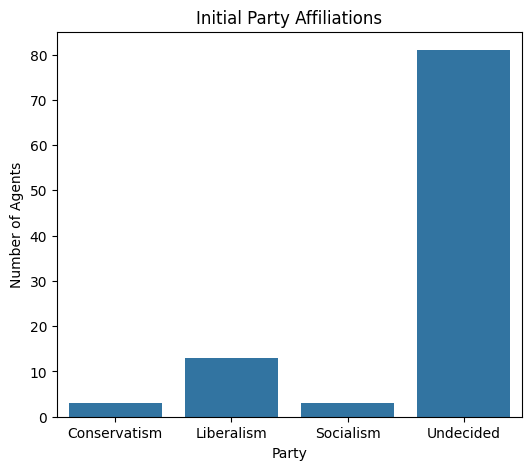

In [359]:
# environment = Environment(100, 10, 10)

# Collect each agent's initial party affiliation
initial_votes = [agent.party_affiliation for agent in environment.agents]

# Count frequencies by party name
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()

# Plot
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Party Affiliations", xlabel="Party", ylabel="Number of Agents")
p.figure.set_size_inches(6, 5)


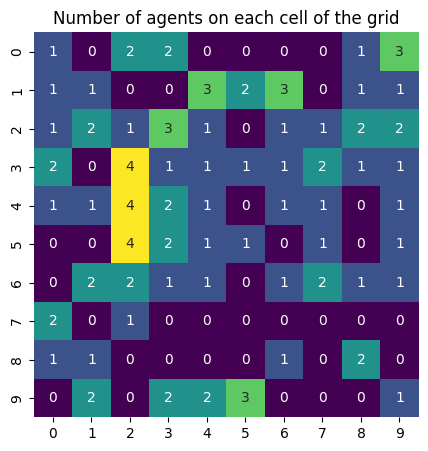

In [360]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

In [343]:
for _ in range(100):
    environment.step()  

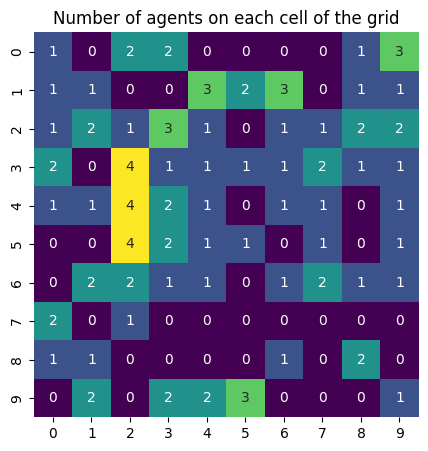

In [361]:
agent_counts = np.zeros((environment.grid.width, environment.grid.height))

for cell in environment.grid.all_cells:
    agent_counts[cell.coordinate] = len(cell.agents)
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

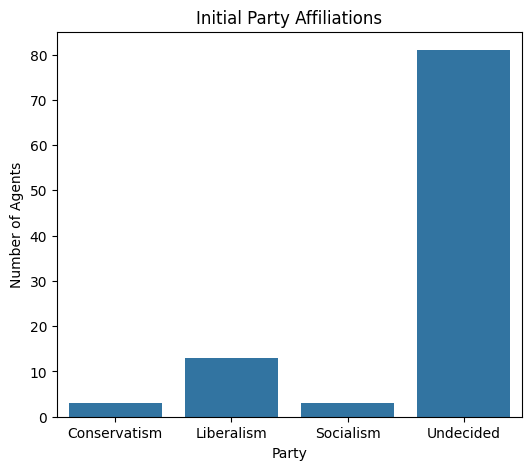

In [362]:
# Collect each agent's initial party affiliation
initial_votes = [agent.party_affiliation for agent in environment.agents]

# Count frequencies by party name
initial_vote_counts = pd.Series(initial_votes).value_counts().sort_index()

# Plot
p = sns.barplot(x=initial_vote_counts.index, y=initial_vote_counts.values)
p.set(title="Initial Party Affiliations", xlabel="Party", ylabel="Number of Agents")
p.figure.set_size_inches(6, 5)


## Dynamic Visualisation

In [363]:
def agent_portrayal(agent):
    return AgentPortrayalStyle(color="tab:orange", size=50)

social_contagion = Environment(n=5, width=3, height=3)  # keyword arguments

In [364]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 3,
        "max": 6,
        "step": 1,
    },
    "width": {
        "type": "SliderInt",
        "value": 3,
        "label": "Width of Grid:",
        "min": 2,
        "max": 6,
        "step": 1,
    },
    "height": {
        "type": "SliderInt",
        "value": 3,
        "label": "Height of Grid:",
        "min": 2,
        "max": 6,
        "step": 1,
    }
}

In [365]:
%%capture

renderer = SpaceRenderer(model=social_contagion, backend="matplotlib")
renderer.draw_structure(lw=2, ls="solid", color="black", alpha=0.1)
renderer.draw_agents(agent_portrayal)

In [366]:
def post_process(ax):
    """Customize the matplotlib axes after rendering."""
    ax.set_title("Social Contagion Model")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_aspect("equal", adjustable="box")


renderer.post_process = post_process

In [367]:
page = SolaraViz(
    social_contagion,
    renderer,
    #components=[BiasPlot],
    model_params=model_params,
    name="Social Contagion ABM",
)

# This is required to render the visualization in a Jupyter notebook
page

Cannot show ipywidgets in text

In [370]:
df = social_contagion.datacollector.get_model_vars_dataframe()
print(df[["vote_Conservatism", "vote_Socialism", "vote_Liberalism", "vote_Undecided"]].head(20))


    vote_Conservatism  vote_Socialism  vote_Liberalism  vote_Undecided
0                   0               0                0               5
1                   0               0                0               5
2                   0               0                0               5
3                   0               1                0               4
4                   0               1                0               4
5                   0               1                0               4
6                   0               1                0               4
7                   0               0                0               5
8                   0               0                0               5
9                   0               1                0               4
10                  0               1                0               4


In [371]:
agent_df = social_contagion.datacollector.get_agent_vars_dataframe()
dist_by_agent = agent_df["distance_from_party"].unstack(level="AgentID")
switch_df = agent_df["switched"].unstack(level="AgentID")

In [372]:
display(dist_by_agent)

AgentID,1,2,3,4,5
Step,,,,,
0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.000000,0.0,22.778877,0.0
4,0.0,0.000000,0.0,22.778877,0.0
5,0.0,0.000000,0.0,22.778877,0.0
6,0.0,0.000000,0.0,22.778877,0.0
7,0.0,0.000000,0.0,0.000000,0.0
8,0.0,0.000000,0.0,0.000000,0.0


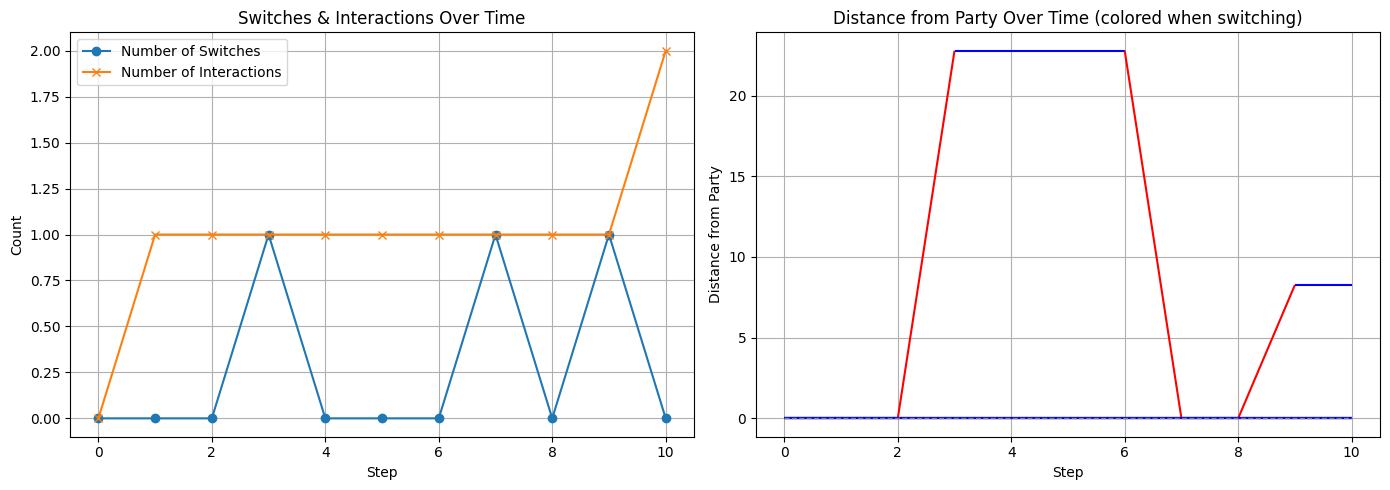

In [373]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# After you’ve run your model:
df = social_contagion.datacollector.get_model_vars_dataframe()
steps = df.index  # define steps

# Also retrieve the agent data and unstack:
agent_df = social_contagion.datacollector.get_agent_vars_dataframe()
dist_by_agent = agent_df["distance_from_party"].unstack(level="AgentID")
switch_df = agent_df["switched"].unstack(level="AgentID")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Left plot: switches & interactions
ax0 = axes[0]
ax0.plot(steps, df["num_switches"], label="Number of Switches", marker="o")
ax0.plot(steps, df["num_interactions"], label="Number of Interactions", marker="x")
ax0.set_xlabel("Step")
ax0.set_ylabel("Count")
ax0.set_title("Switches & Interactions Over Time")
ax0.legend()
ax0.grid(True)

# Right plot: distance from party with colored switching segments
ax1 = axes[1]

for agent_id in dist_by_agent.columns:
    y = dist_by_agent[agent_id].values
    x = dist_by_agent.index.values  # these are your steps

    # Create line segments between consecutive (x, y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Decide color per segment — check switch_df at the destination step
    colors = []
    for i in range(len(x) - 1):
        sw = switch_df.loc[x[i+1], agent_id]
        colors.append("red" if sw else "blue")

    lc = LineCollection(segments, colors=colors, linewidths=1.5)
    ax1.add_collection(lc)

# Optionally draw a horizontal threshold line, e.g. at y = 0 (or any value)
threshold = 0
ax1.hlines(y=threshold,
           xmin=dist_by_agent.index.min(),
           xmax=dist_by_agent.index.max(),
           colors="gray", linestyles="--", linewidth=1)

ax1.set_xlabel("Step")
ax1.set_ylabel("Distance from Party")
ax1.set_title("Distance from Party Over Time (colored when switching)")
ax1.autoscale()
ax1.grid(True)

plt.tight_layout()
plt.show()
